## Instalar librerías

In [22]:
!pip install transformers==4.56.1 datasets evaluate torch --quiet

## Importar librerías

In [21]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

###Agregar clave de Hugging Face

In [ ]:
from huggingface_hub import login
login()

In [ ]:

import os
os.environ["WANDB_DISABLED"] = "true"

## Cargar dataset IMDb

In [ ]:
dataset = load_dataset("imdb")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Tokenizador

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Reducir dataset para demo rápida

In [ ]:

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(5000))


## Cargar modelo preentrenado

In [ ]:

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Métrica con evaluate

In [ ]:

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Configuración de entrenamiento | Definir Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # eval cada época
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    dataloader_drop_last=False,
    weight_decay=0.01,
    logging_dir="./logs",
    optim='adamw_torch', # Set optimizer to adamw_torch to avoid the fused optimizer issue
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


# Entrenar modelo (fine-tuning)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3406240107.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.231200,0.217415,0.926256
2,0.146000,0.244975,0.930308


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=3126, training_loss=0.20435529356191956, metrics={'train_runtime': 444.2161, 'train_samples_per_second': 112.594, 'train_steps_per_second': 7.037, 'total_flos': 6623369932800000.0, 'train_loss': 0.20435529356191956, 'epoch': 2.0})

## Probar el modelo con un ejemplo

In [ ]:
text = "I really loved this movie, it was fantastic!"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Mover al dispositivo que usa el Trainer (TPU o GPU)
device = model.device
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs).item()

labels = {0: "NEGATIVE", 1: "POSITIVE"}
print(f"Texto: {text}")
print(f"Predicción: {labels[pred]}, Probabilidades: {probs}")

Texto: I really loved this movie, it was fantastic!
Predicción: POSITIVE, Probabilidades: tensor([[0.0038, 0.9962]], device='xla:0')


#Evaluacición para comparar con los resultados de 02_LSTM_vs_Transformer

### ---------- 1. Predicciones sobre el conjunto de test ----------

In [ ]:

import time, evaluate, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print("Generando predicciones sobre test...")
start_eval = time.time()

# batch_size grande para acelerar
preds_output = trainer.predict(small_test_dataset)
y_pred_prob  = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=-1)[:, 1].numpy()
y_pred       = (y_pred_prob >= 0.5).astype(int)
y_true       = small_test_dataset["label"]

elapsed_eval = time.time() - start_eval


Generando predicciones sobre test...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### ---------- 2. Métricas ----------

In [ ]:
cls_report = classification_report(y_true[:len(y_pred)], y_pred, target_names=["NEGATIVE", "POSITIVE"], output_dict=True)
f1_macro   = cls_report["macro avg"]["f1-score"]
accuracy   = cls_report["accuracy"]

print("\nClassification report:")
print(classification_report(y_true[:len(y_pred)], y_pred, target_names=["NEGATIVE", "POSITIVE"]))



Classification report:
              precision    recall  f1-score   support

    NEGATIVE       0.91      0.88      0.89      2465
    POSITIVE       0.88      0.91      0.89      2471

    accuracy                           0.89      4936
   macro avg       0.89      0.89      0.89      4936
weighted avg       0.89      0.89      0.89      4936



### ---------- 3. Matriz de confusión ----------

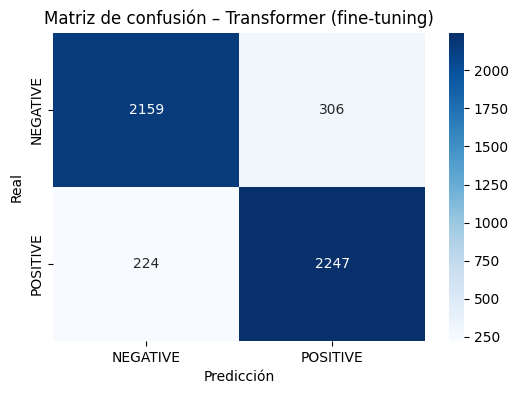

In [ ]:

plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_true[:len(y_pred)], y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NEGATIVE", "POSITIVE"],
            yticklabels=["NEGATIVE", "POSITIVE"])
plt.title("Matriz de confusión – Transformer (fine-tuning)")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()


### ---------- 4. Tiempo de entrenamiento ----------
### `trainer` guarda la historia en `trainer.state.log_history`

In [ ]:
train_time_sec = trainer.state.log_history[-1]["train_runtime"]  # está en segundos

### ---------- 5. Resumen en CSV ----------

In [ ]:
summary_df = pd.DataFrame([{
    "modelo": "Transformer (fine-tune)",
    "accuracy": accuracy,
    "F1_macro": f1_macro,
    "loss": preds_output.metrics["test_loss"],  # devuelto por Trainer
    "epochs": trainer.args.num_train_epochs,
    "params": model.num_parameters(),
    "training_time_sec": round(train_time_sec, 1),
    "eval_time_sec": round(elapsed_eval, 1)
}])

summary_df.to_csv("03_Transformer_Fine_Tuning.csv", index=False)
print("\nResumen guardado en → 03_Transformer_Fine_Tuning.csv")
summary_df